In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset_constructor import MarketData
from backtest import Backtest
from visualization.visualize_backtest import visualize_backtest

from strategy.indicator_based.moving_average_strategy import MovingAverageCrossoverStrategy
from strategy.indicator_based.macd_strategy import MACDStrategy
from strategy.indicator_based.rsi_strategy import RSIStrategy2

from strategy.ensemble.majority_voting_strategy import MajorityVotingStrategy
from strategy.ensemble.weighted_voting_strategy import WeightedVotingStrategy

import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

sharpe_ratio: 0.7680
max_drawdown: -0.6673


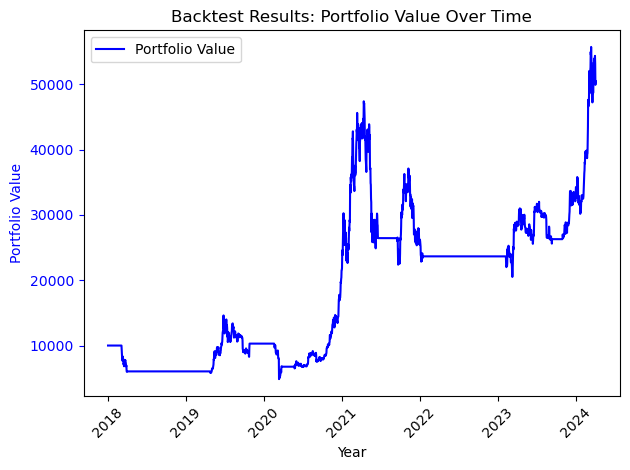

sharpe_ratio: 0.5799
max_drawdown: -0.5749


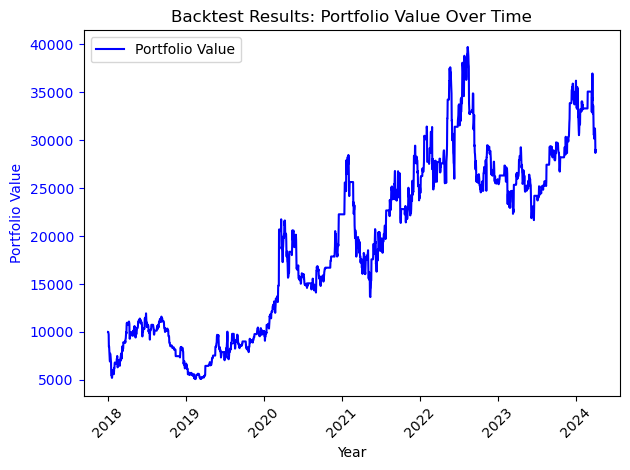

sharpe_ratio: 0.6202
max_drawdown: -0.5791


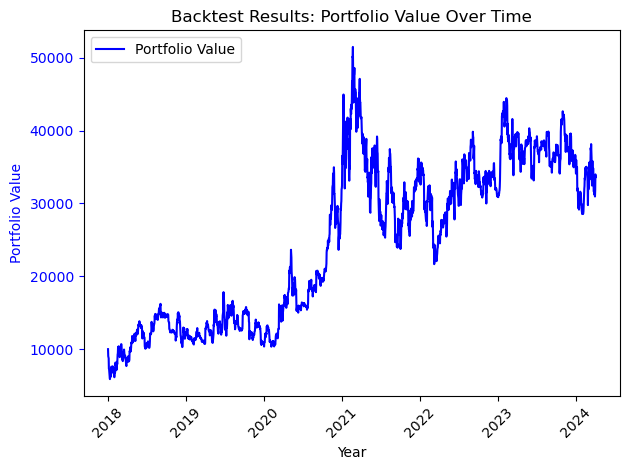

In [2]:
file_path = '../../data/crypto/csv/BTC_USDT_1d.csv'
market_data = MarketData(file_path)

weights_sharpe_ratio, weights_max_drawdown, weights_portfolio_value = [],[],[]
strategy1 = MovingAverageCrossoverStrategy(market_data.data)
strategy2 = RSIStrategy2(market_data.data)
strategy3 = MACDStrategy(market_data.data)
strategys = [strategy1, strategy2, strategy3]

for startegy in strategys:
    backtest = Backtest(market_data.data, startegy, start_date='2018-01-01', end_date=None, fee=2e-4)
    backtest.run()
    portfolio = backtest.simulate_trades(initial_capital=10000)
    metrics = backtest.calculate_metrics()

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    visualize_backtest(portfolio)

    weights_sharpe_ratio.append(metrics['sharpe_ratio'])
    weights_max_drawdown.append(metrics['max_drawdown'])
    weights_portfolio_value.append(portfolio['total'].iloc[-1])

sharpe_ratio: 0.8676
max_drawdown: -0.5380


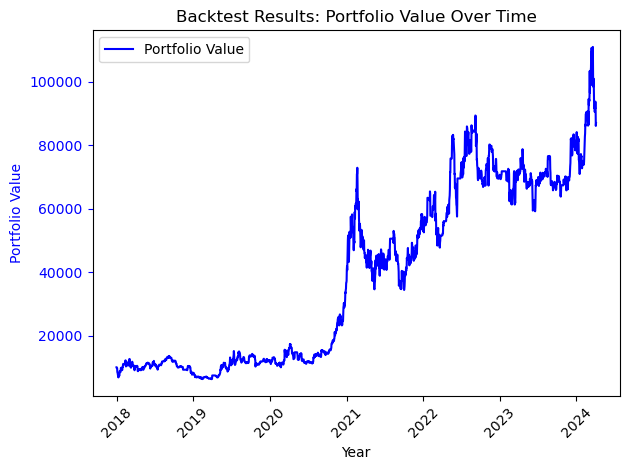

In [3]:

file_path = '../../data/crypto/csv/BTC_USDT_1d.csv'
market_data = MarketData(file_path)

ensemble_strategy = MajorityVotingStrategy(market_data.data, [strategy1, strategy2, strategy3])
backtest = Backtest(market_data.data, ensemble_strategy, start_date='2018-01-01', end_date=None, fee=2e-4, enable_logging=False)
# Assuming backtest and initial_capital are already defined
backtest.run()
portfolio = backtest.simulate_trades(initial_capital=10000)
metrics = backtest.calculate_metrics()

# Output metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualize the backtest
visualize_backtest(portfolio)

sharpe_ratio: 1.1233
max_drawdown: -0.4549


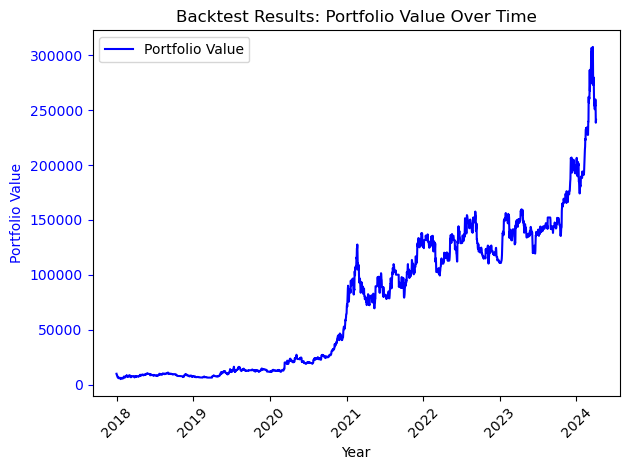

In [4]:
file_path = '../../data/crypto/csv/BTC_USDT_1d.csv'
market_data = MarketData(file_path)

ensemble_strategy = WeightedVotingStrategy(market_data.data, [strategy1, strategy2, strategy3])
backtest = Backtest(market_data.data, ensemble_strategy, start_date='2018-01-01', end_date=None, fee=2e-4)
# Assuming backtest and initial_capital are already defined
backtest.run()
portfolio = backtest.simulate_trades(initial_capital=10000)
metrics = backtest.calculate_metrics()

# Output metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualize the backtest
visualize_backtest(portfolio)

In [5]:
strategies_metrics = pd.DataFrame({
    'strategy': ['Strategy 1', 'Strategy 2', 'Strategy 3'],
    'sharpe_ratio': weights_sharpe_ratio,
    'max_drawdown': weights_max_drawdown,
    'final_portfolio_value': weights_portfolio_value
})

strategies_metrics['weights_sharpe_ratio'] = (strategies_metrics['sharpe_ratio'] - strategies_metrics['sharpe_ratio'].min()) / (strategies_metrics['sharpe_ratio'].max() - strategies_metrics['sharpe_ratio'].min())
strategies_metrics['weights_max_drawdown'] = (strategies_metrics['max_drawdown'].max() - strategies_metrics['max_drawdown']) / (strategies_metrics['max_drawdown'].max() - strategies_metrics['max_drawdown'].min())
strategies_metrics['weights_portfolio_value'] = (strategies_metrics['final_portfolio_value'] - strategies_metrics['final_portfolio_value'].min()) / (strategies_metrics['final_portfolio_value'].max() - strategies_metrics['final_portfolio_value'].min())

strategies_metrics['final_weight'] = strategies_metrics[['weights_sharpe_ratio', 'weights_max_drawdown', 'weights_portfolio_value']].mean(axis=1)

sharpe_ratio: 0.8201
max_drawdown: -0.7809


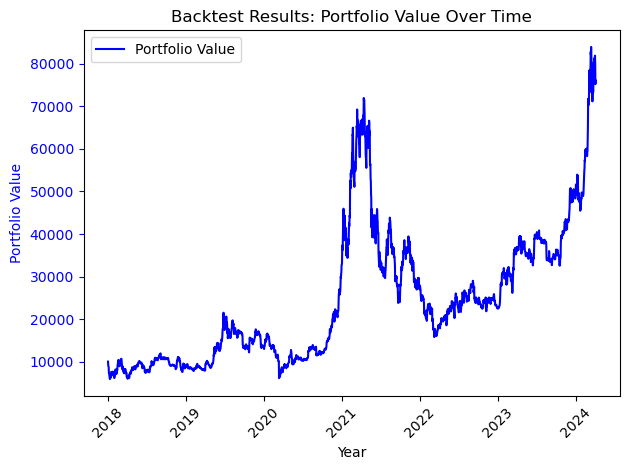

In [6]:
file_path = '../../data/crypto/csv/BTC_USDT_1d.csv'
market_data = MarketData(file_path)

ensemble_strategy = WeightedVotingStrategy(market_data.data, strategies=[strategy1, strategy2, strategy3], weights=strategies_metrics['final_weight'])
backtest = Backtest(market_data.data, ensemble_strategy, start_date='2018-01-01', end_date=None, fee=2e-4, leverage=1)
# Assuming backtest and initial_capital are already defined
backtest.run()
portfolio = backtest.simulate_trades(initial_capital=10000)
metrics = backtest.calculate_metrics()

# Output metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualize the backtest
visualize_backtest(portfolio)